# Bayesian Analysis on Digital Asset Data

### Background

Digital asset markets operate 24/7.<br/>
For a given asset e.g., BTC, ETH, multiple markes/pairs may exist.
The most actively traded ones ar spot and perptual markets.
- In spot markets, the actual asset is traded directly
- In perpetual markets, derivatives of the asset are traded.
  
Although the price in these markets are correlated, they are oten not identical.

---

**Bid and Ask** <br/>
There are twwo types of prices:
- The **bid** price represents the price that a buyer is willing to pay for an asset
- The **ask** price is the price that a seller is willing to accept
- The **best bid** is the highest among all bid offers in the market
- The **best ask** is the lowest among all ask offers

---
**Reaction Time**

On Binance, the reaction tim between these two markets is typically around 3-5 milliseconds (ms). A sudden price movement in one market is usually rflected in the other within 3-5 ms. However, not every price movement is reliable - some revert to their original level before affecting the other market.

#### Dataset

The data used is TRB/USDT pair

In [86]:
import pymc as pm
import arviz as az
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio

In [87]:
pio.renderers.default="notebook"

In [2]:
df_spot = pd.read_csv('./data/trb_usdt_futures_export.csv')
df_spot_trade = pd.read_csv('./data/trb_usdt_trades_export.csv')
df_perpetual = pd.read_csv('./data/trb_usdt_spot_export.csv')

In [3]:
df_spot['time'] = pd.to_datetime(df_spot['time'], format='mixed', errors='coerce')
df_spot_trade['time'] = pd.to_datetime(df_spot_trade['time'], format='mixed', errors='coerce')
df_perpetual['time'] = pd.to_datetime(df_perpetual['time'], format='mixed', errors='coerce')

In [4]:
print(df_spot['time'].isna().sum())
print(df_spot_trade['time'].isna().sum())
print(df_perpetual['time'].isna().sum())

0
0
0


In [5]:
df_spot.info(), df_spot_trade.info(), df_perpetual.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5593820 entries, 0 to 5593819
Data columns (total 4 columns):
 #   Column     Dtype              
---  ------     -----              
 0   time       datetime64[ns, UTC]
 1   symbol     object             
 2   bid_price  float64            
 3   ask_price  float64            
dtypes: datetime64[ns, UTC](1), float64(2), object(1)
memory usage: 170.7+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 291966 entries, 0 to 291965
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype              
---  ------           --------------   -----              
 0   time             291966 non-null  datetime64[ns, UTC]
 1   symbol           291966 non-null  object             
 2   price            291966 non-null  float64            
 3   quantity         291966 non-null  float64            
 4   is_market_maker  291966 non-null  object             
dtypes: datetime64[ns, UTC](1), float64(2), object(2)
memory usage: 11.

(None, None, None)

### Add Timedelta in MS

In [6]:
df_spot = df_spot.sort_values('time').reset_index(drop=True)
df_spot_trade=df_spot_trade.sort_values('time').reset_index(drop=True)
df_perpetual=df_perpetual.sort_values('time').reset_index(drop=True)

In [7]:
df_spot['mid_price'] = (df_spot['bid_price']+df_spot['ask_price'])/2
df_perpetual['mid_price'] = (df_perpetual['bid_price']+df_perpetual['ask_price'])/2

In [8]:
df_spot.set_index(df_spot.time, drop=True, inplace=True)
df_spot_trade.set_index(df_spot_trade.time, drop=True, inplace=True)
df_perpetual.set_index(df_perpetual.time, drop=True, inplace=True)

In [9]:
df_spot['timedelta_ms'] = df_spot.sort_index().index.to_series().diff().dt.total_seconds() * 1000

### Add Rolling Window Features and Percentage Change of Each Window

In [10]:
df_spot['window_3'] = df_spot['mid_price'].sort_index().rolling(window='3ms', min_periods=2).mean().shift(1)
df_spot['window_4'] = df_spot['mid_price'].sort_index().rolling(window='4ms', min_periods=2).mean().shift(1)
df_spot['window_5'] = df_spot['mid_price'].sort_index().rolling(window='5ms', min_periods=2).mean().shift(1)

df_spot['window_3_pct_change'] = np.round(df_spot['window_3'].sort_index().pct_change(),4)
df_spot['window_4_pct_change'] =  np.round(df_spot['window_4'].sort_index().pct_change(),4)
df_spot['window_5_pct_change'] =  np.round(df_spot['window_5'].sort_index().pct_change(),4)

/tmp/ipykernel_43361/3203040253.py:5: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df_spot['window_3_pct_change'] = np.round(df_spot['window_3'].sort_index().pct_change(),4)
/tmp/ipykernel_43361/3203040253.py:6: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df_spot['window_4_pct_change'] =  np.round(df_spot['window_4'].sort_index().pct_change(),4)
/tmp/ipykernel_43361/3203040253.py:7: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method

#### Spot Data

In [11]:
df_spot.describe().T

,count,mean,std,min,25%,50%,75%,max
bid_price,5593820.0,5.008016e+01,2.861972,43.016000,48.865000,50.644000,51.918000,56.861000
ask_price,5593820.0,5.008953e+01,2.863358,43.020000,48.874000,50.651000,51.927000,56.880000
mid_price,5593820.0,5.008485e+01,2.862653,43.019000,48.869000,50.647000,51.922500,56.870500
timedelta_ms,5593819.0,1.532595e+01,57.603564,0.000000,1.000000,2.000000,6.000000,8223.000000
window_3,3599626.0,5.018051e+01,2.837366,43.020400,48.935000,50.674112,51.972750,56.859667
window_4,3895144.0,5.017096e+01,2.841975,43.021556,48.922717,50.670750,51.968833,56.853417
window_5,4050393.0,5.016446e+01,2.845426,43.020833,48.914250,50.668250,51.966250,56.854563
window_3_pct_change,5593816.0,6.578693e-09,0.000049,-0.009100,0.000000,0.000000,0.000000,0.006100
window_4_pct_change,5593816.0,2.241761e-08,0.000046,-0.008100,0.000000,0.000000,0.000000,0.005600
window_5_pct_change,5593817.0,3.661185e-08,0.000044,-0.010200,0.000000,0.000000,0.000000,0.005600


In [12]:
df_spot.symbol.value_counts()

symbol
TRB_USDT    5593820
Name: count, dtype: int64

In [13]:
df_spot.head(10)

,time,symbol,bid_price,ask_price,mid_price,timedelta_ms,window_3,window_4,window_5,window_3_pct_change,window_4_pct_change,window_5_pct_change
time,,,,,,,,,,,,
2025-05-27 12:00:00.025000+00:00,2025-05-27 12:00:00.025000+00:00,TRB_USDT,43.140,43.141,43.1405,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-05-27 12:00:00.029000+00:00,2025-05-27 12:00:00.029000+00:00,TRB_USDT,43.138,43.140,43.1390,4.0,NaN,NaN,NaN,NaN,NaN,NaN
2025-05-27 12:00:00.029000+00:00,2025-05-27 12:00:00.029000+00:00,TRB_USDT,43.138,43.141,43.1395,0.0,NaN,NaN,43.139750,NaN,NaN,NaN
2025-05-27 12:00:02.470000+00:00,2025-05-27 12:00:02.470000+00:00,TRB_USDT,43.134,43.140,43.1370,2441.0,43.139250,43.139250,43.139667,NaN,NaN,-0.0000
2025-05-27 12:00:02.478000+00:00,2025-05-27 12:00:02.478000+00:00,TRB_USDT,43.133,43.137,43.1350,8.0,NaN,NaN,NaN,0.0000,0.0000,0.0000
2025-05-27 12:00:02.478000+00:00,2025-05-27 12:00:02.478000+00:00,TRB_USDT,43.134,43.139,43.1365,0.0,NaN,NaN,NaN,0.0000,0.0000,0.0000
2025-05-27 12:00:02.478000+00:00,2025-05-27 12:00:02.478000+00:00,TRB_USDT,43.133,43.134,43.1335,0.0,43.135750,43.135750,43.135750,-0.0001,-0.0001,-0.0001
2025-05-27 12:00:02.478000+00:00,2025-05-27 12:00:02.478000+00:00,TRB_USDT,43.134,43.137,43.1355,0.0,43.135000,43.135000,43.135000,-0.0000,-0.0000,-0.0000
2025-05-27 12:00:02.478000+00:00,2025-05-27 12:00:02.478000+00:00,TRB_USDT,43.133,43.137,43.1350,0.0,43.135125,43.135125,43.135125,0.0000,0.0000,0.0000


### Linear Model

In [25]:
df_spot.dropna(inplace=True)
df_spot_sample = df_spot.sample(30000, random_state=42)

In [26]:
y_data = df_spot_sample['window_3_pct_change'].values
X_data = df_spot_sample[['timedelta_ms', 'mid_price']].values

In [27]:
with pm.Model() as model_3ms:
    # priors
    a = pm.Normal('a', mu=0, sigma=1)
    beta = pm.Normal('beta', mu=0, sigma=1, shape=X_data.shape[1])
    sigma = pm.HalfNormal('sigma', 1)

    # linear model
    u = pm.Deterministic('mu', a+pm.math.dot(X_data, beta))

    # likelihood
    y_obs = pm.Normal('y', mu=u, sigma=sigma, observed=y_data)

    # inference
    idata_3ms = pm.sample(idata_kwargs={'log_likelihood':True})
    idata_3ms.extend(pm.sample_posterior_predictive(idata_3ms))

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 99 seconds.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Sampling: [y]


Output()

### Visual Representation of Linear 3ms Model

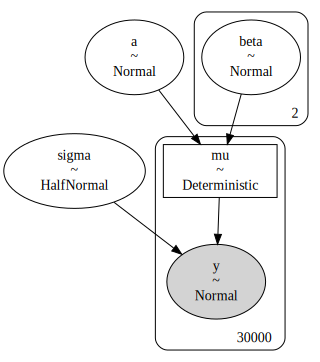

In [28]:
pm.model_to_graphviz(model_3ms)

### Posterior Check

In [50]:
idata_3ms.posterior

<xarray.Dataset> Size: 960MB
Dimensions:     (chain: 4, draw: 1000, beta_dim_0: 2, mu_dim_0: 30000)
Coordinates:
  * chain       (chain) int64 32B 0 1 2 3
  * draw        (draw) int64 8kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * beta_dim_0  (beta_dim_0) int64 16B 0 1
  * mu_dim_0    (mu_dim_0) int64 240kB 0 1 2 3 4 ... 29996 29997 29998 29999
Data variables:
    a           (chain, draw) float64 32kB -2.108e-06 5.25e-06 ... -1.486e-05
    beta        (chain, draw, beta_dim_0) float64 64kB 6.919e-09 ... 2.924e-07
    sigma       (chain, draw) float64 32kB 6.734e-05 6.719e-05 ... 6.689e-05
    mu          (chain, draw, mu_dim_0) float64 960MB 3.056e-07 ... 4.121e-07
    mu_mean     (chain, draw) float64 32kB 6.378e-07 3.948e-07 ... 6.324e-07
Attributes:
    created_at:                 2025-06-29T17:58:01.785929+00:00
    arviz_version:              0.21.0
    inference_library:          pymc
    inference_library_version:  5.23.0
    sampling_time:              99.22949028015137
    tuning_steps:               1000

In [51]:
mu_mean = idata_3ms.posterior["mu"].mean(dim=("mu_dim_0"))  # shape: [chain, draw]

In [52]:
idata_3ms.posterior['mu_mean'] = mu_mean

In [78]:
spot_population_mean_3pct_change = np.mean(df_spot['window_3_pct_change']) * 100
print(f"Mean percentage change of spot population: {spot_population_mean_3pct_change:.8f}%")

Mean percentage change of spot population: 0.00000102%


[]

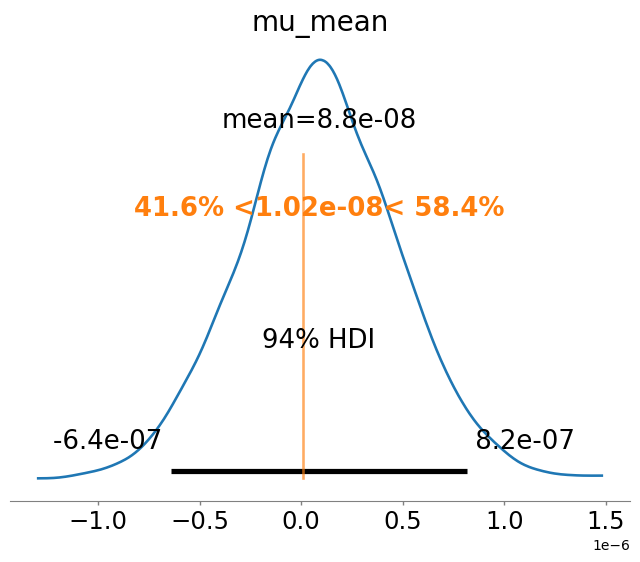

In [84]:
az.plot_posterior(idata_3ms, var_names=['mu_mean'], figsize=(8,6), ref_val=0.0000000102)
plt.plot()

- The curve above shows that the mean percentage change within a 3 ms window is approximately 0.0000088%, with 94% probability that the true mean lies between -0.000064% and 0.000082%.
- The lower bound of the 94% highest density interval (HDI) is negative, suggesting the possibility of a slight decrease in price, while the upper bound indicates a potential slight increase.
- The empirical mean of the spot price change population is 0.00000102%, which falls within the 94% HDI and is very close to the posterior mean, supporting the model's validity.
- The posterior mean of percentage change over 3 ms for the 30,000 sampled observations is close to zero, indicating that there is insufficient evidence to support the claim that the price typically moves by as much as ±0.007% (7 bps) within a 3 ms window.